In [2]:
!pip install findspark

In [4]:
!which java



/usr/lib/jvm/java-17-openjdk-amd64/bin/java


In [5]:
!readlink -f $(which java)


/usr/lib/jvm/java-17-openjdk-amd64/bin/java


In [7]:
import os
#0. SPARK and java INITIALIZATION

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("WineQualityAnalysis") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

print("Spark version:", spark.version)

#test
spark.range(5).show()



Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/26 10:42:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark version: 4.0.1
+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+



In [10]:
# ============================================================
# 1. LOAD WINE DATASET INTO SPARK DATAFRAMES
# ============================================================
from pyspark.sql.functions import lit

# Read wine CSV files with Spark
red = spark.read.csv("DATA/winequality-red.csv", header=True, sep=";", inferSchema=True)
white = spark.read.csv("DATA/winequality-white.csv", header=True, sep=";", inferSchema=True)

# Add wine type columns
red = red.withColumn("type", lit("red"))
white = white.withColumn("type", lit("white"))

# Merge datasets
wine = red.union(white)

# Show sample
wine.show(5)


+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+----+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|type|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+----+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5| red|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5| red|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5| red|
|         11.2|            0.28|       0.56|           1.9|    0.075| 

In [11]:
# ============================================================
# 2. BASIC STRUCTURE CHECK
# ============================================================

# Print schema
wine.printSchema()

# Check missing values per column
from pyspark.sql.functions import col, sum as sum_

wine.select([sum_(col(c).isNull().cast("int")).alias(c) for c in wine.columns]).show()

# Summary statistics for numeric columns
wine.describe().show()


root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)
 |-- type: string (nullable = false)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+----+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density| pH|sulphates|alcohol|quality|type|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+--------

25/11/26 10:44:30 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+-------------------+-------------------+------------------+-------------------+-------------------+--------------------+--------------------+-------------------+-------------------+------------------+------------------+-----+
|summary|    fixed acidity|   volatile acidity|        citric acid|    residual sugar|          chlorides|free sulfur dioxide|total sulfur dioxide|             density|                 pH|          sulphates|           alcohol|           quality| type|
+-------+-----------------+-------------------+-------------------+------------------+-------------------+-------------------+--------------------+--------------------+-------------------+-------------------+------------------+------------------+-----+
|  count|             6497|               6497|               6497|              6497|               6497|               6497|                6497|                6497|               6497|               6497|              6497|              

In [12]:
# ============================================================
# 3. CORRELATION MATRIX USING SPARK ML
# ============================================================

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import *

# Select only numeric columns
numeric_cols = [c for c, t in wine.dtypes if t in ("double", "int")]

# Assemble Spark vector
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vec = assembler.transform(wine).select("features")

# Compute Pearson correlation
corr_matrix = Correlation.corr(df_vec, "features", "pearson").head()[0].toArray()

corr_matrix


25/11/26 10:44:40 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


array([[ 1.        ,  0.21900826,  0.32443573, -0.11198128,  0.29819477,
        -0.28273543, -0.3290539 ,  0.45890998, -0.25270047,  0.29956774,
        -0.09545152, -0.07674321],
       [ 0.21900826,  1.        , -0.37798132, -0.19601117,  0.37712428,
        -0.35255731, -0.41447619,  0.27129565,  0.2614544 ,  0.22598368,
        -0.03764039, -0.26569948],
       [ 0.32443573, -0.37798132,  1.        ,  0.14245123,  0.03899801,
         0.13312581,  0.19524198,  0.09615393, -0.32980819,  0.0561973 ,
        -0.01049349,  0.08553172],
       [-0.11198128, -0.19601117,  0.14245123,  1.        , -0.1289405 ,
         0.40287064,  0.49548159,  0.55251695, -0.26731984, -0.18592741,
        -0.35941477, -0.03698048],
       [ 0.29819477,  0.37712428,  0.03899801, -0.1289405 ,  1.        ,
        -0.19504479, -0.27963045,  0.36261466,  0.04470798,  0.39559331,
        -0.25691558, -0.2006655 ],
       [-0.28273543, -0.35255731,  0.13312581,  0.40287064, -0.19504479,
         1.        ,  

In [ ]:
#conclusion:Higher alcohol and lower density or volatile acidity are the strongest linear indicators of better wine quality, while most other features show only weak or marginal relationships.

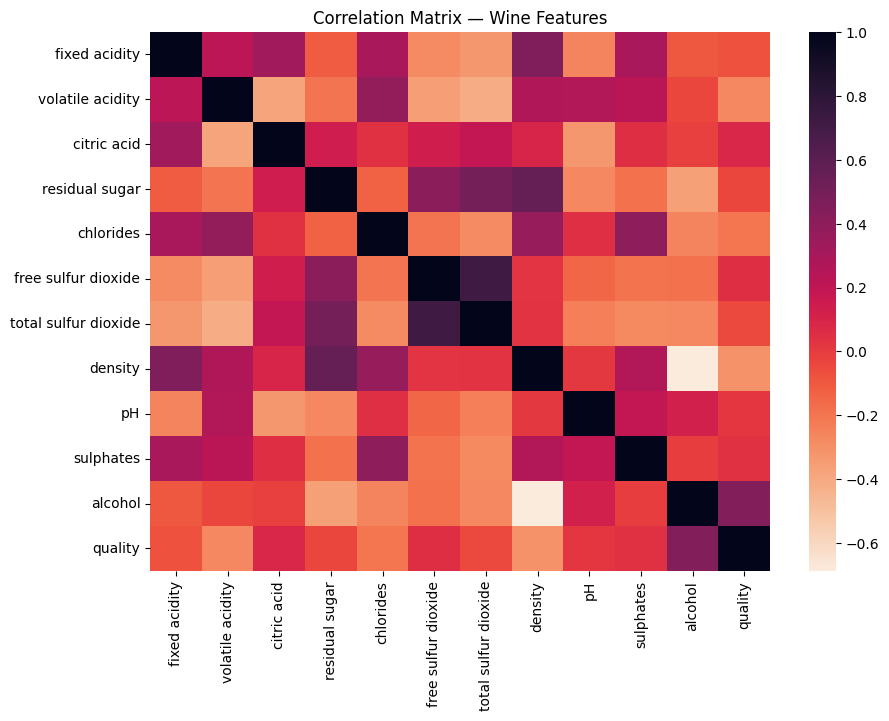

In [13]:

# 4. plot correlation heatmap


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10,7))
sns.heatmap(corr_matrix, cmap="rocket_r", xticklabels=numeric_cols, yticklabels=numeric_cols)
plt.title("Correlation Matrix — Wine Features")
plt.show()


In [37]:
# 2 version with pipelins, RF Z 500 DRZEW 
#5 
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

indexer = StringIndexer(inputCol="type", outputCol="type_encoded")
#6
feature_cols = [c for c in wine.columns if c not in ("quality", "type")]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="assembled")
#dodatek skaler bo ma być:StringIndexer → Assembler → Scaler → Model

scaler = StandardScaler(inputCol="assembled", outputCol="features")
#7?
#8
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="quality",
    numTrees=500
)



In [38]:
#7
from pyspark.ml import Pipeline

pipeline_reg = Pipeline(stages=[
    indexer,
    assembler,
    scaler,
    rf
])

train_reg, test_reg = wine.randomSplit([0.7, 0.3], seed=42)
model_reg = pipeline_reg.fit(train_reg)

pred_reg = model_reg.transform(test_reg)
pred_reg.show(5)


25/11/26 11:32:47 WARN DAGScheduler: Broadcasting large task binary with size 1247.2 KiB
25/11/26 11:32:48 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+----+------------+--------------------+--------------------+-----------------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|type|type_encoded|           assembled|            features|       prediction|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+----+------------+--------------------+--------------------+-----------------+
|          4.9|            0.42|        0.0|           2.1|    0.048|               16.0|                42.0|0.99154|3.71|     0.74|   14.0|      7| red|         1.0|[4.9,0.42,0.0,2.1...|[3.79978170064518...|6.508581177252108|
|          5.0|            0.74|        0.0|           1.2|    0.041|               16.0

In [39]:

# 9.evaluation


from pyspark.ml.evaluation import RegressionEvaluator

rmse_eval = RegressionEvaluator(labelCol="quality", predictionCol="prediction", metricName="rmse")
r2_eval = RegressionEvaluator(labelCol="quality", predictionCol="prediction", metricName="r2")

rmse = rmse_eval.evaluate(pred_reg)
r2 = r2_eval.evaluate(pred_reg)


print("RMSE:", rmse)
print("R²:", r2)


RMSE: 0.6990519443229632
R²: 0.33679186855373167


In [40]:

# 10. featrue importance

#?
import pandas as pd

rf_model = model_reg.stages[-1]  # ostatni element pipeline
importances = rf_model.featureImportances.toArray()


# convert to pandas to have a  plot
fi = pd.Series(importances, index=feature_cols).sort_values(ascending=False)

fi.head(10)


alcohol                 0.387205
volatile acidity        0.134287
density                 0.132748
chlorides               0.072417
free sulfur dioxide     0.071873
citric acid             0.063765
sulphates               0.042631
residual sugar          0.031973
total sulfur dioxide    0.026984
fixed acidity           0.019541
dtype: float64

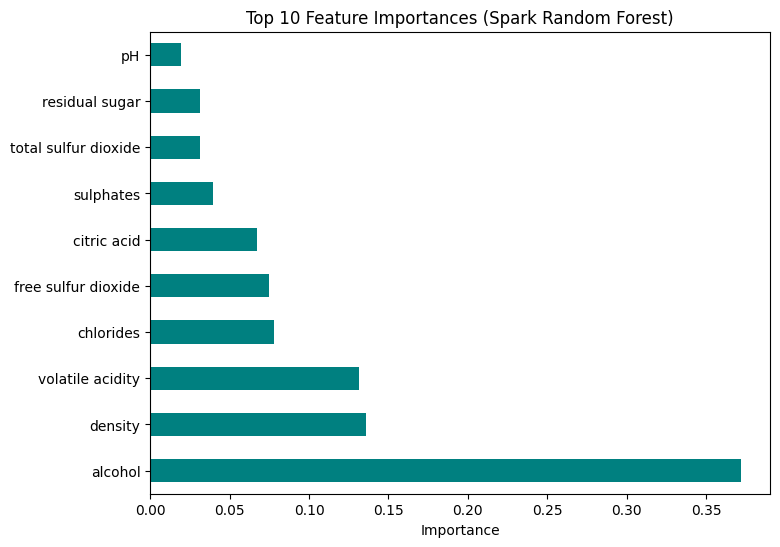

In [22]:
# 11. feature importance plot


plt.figure(figsize=(8,6))
fi.head(10).plot(kind="barh", color="teal")
plt.title("Top 10 Feature Importances (Spark Random Forest)")
plt.xlabel("Importance")
plt.show()


In [23]:
#12-14 z pipeline
wine_clf = wine.withColumn("label", (col("quality") >= 7).cast("int"))

assembler_clf = VectorAssembler(
    inputCols=[c for c in wine_clf.columns if c not in ("quality", "type", "label")],
    outputCol="assembled"
)

scaler_clf = StandardScaler(inputCol="assembled", outputCol="features")

from pyspark.ml.classification import RandomForestClassifier
rf_clf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=200)

pipeline_clf = Pipeline(stages=[
    indexer,
    assembler_clf,
    scaler_clf,
    rf_clf
])

train_clf, test_clf = wine_clf.randomSplit([0.7,0.3], seed=42)
model_clf = pipeline_clf.fit(train_clf)
pred_clf = model_clf.transform(test_clf)
pred_clf.show(5)


+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+----+-----+------------+--------------------+--------------------+--------------------+--------------------+----------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|type|label|type_encoded|           assembled|            features|       rawPrediction|         probability|prediction|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+----+-----+------------+--------------------+--------------------+--------------------+--------------------+----------+
|          4.9|            0.42|        0.0|           2.1|    0.048|               16.0|                42.0|0.99154|3.71|     0.74|   14.0|      7| red|    1|         1.0|[4.9,0.42,0.0,2.1...

25/11/26 10:49:54 WARN DAGScheduler: Broadcasting large task binary with size 1117.7 KiB


25/11/26 10:50:31 WARN DAGScheduler: Broadcasting large task binary with size 1082.5 KiB


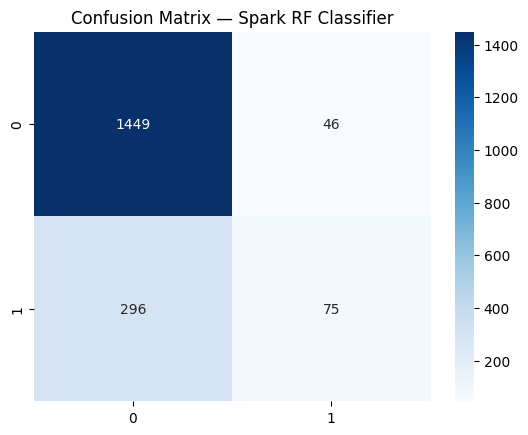

In [25]:

# 15. confusion matrix, and convertion spark-pandas-heatmap

from sklearn.metrics import confusion_matrix

y_true = pred_clf.select("label").toPandas()
y_pred = pred_clf.select("prediction").toPandas()

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — Spark RF Classifier")
plt.show()


In [26]:

# 16. PCA + KMEANS additional


from pyspark.ml.feature import PCA, StandardScaler, VectorAssembler
from pyspark.ml.clustering import KMeans

numeric_cols = [c for c, t in wine.dtypes if t in ("double", "int")]

assembler_u = VectorAssembler(inputCols=numeric_cols, outputCol="assembled")
scaler_u = StandardScaler(inputCol="assembled", outputCol="scaled")
pca = PCA(k=2, inputCol="scaled", outputCol="pca_features")
kmeans = KMeans(k=3, featuresCol="pca_features", seed=42)

pipeline_unsup = Pipeline(stages=[assembler_u, scaler_u, pca, kmeans])
model_unsup = pipeline_unsup.fit(wine)

clusters = model_unsup.transform(wine)
clusters.select("pca_features", "prediction").show(5)



25/11/26 10:50:38 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+--------------------+----------+
|        pca_features|prediction|
+--------------------+----------+
|[-39.543464804415...|         1|
|[-39.423631308088...|         1|
|[-39.432503504918...|         1|
|[-37.867716167866...|         1|
|[-39.543464804415...|         1|
+--------------------+----------+
only showing top 5 rows


In [27]:
#PCA w Spark ML
from pyspark.ml.feature import PCA, StandardScaler, VectorAssembler

# Select numeric columns
numeric_cols = [c for c, t in wine.dtypes if t in ("double", "int")]

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="vec")
df_vec = assembler.transform(wine)

scaler = StandardScaler(inputCol="vec", outputCol="scaled")
df_scaled = scaler.fit(df_vec).transform(df_vec)

pca = PCA(k=2, inputCol="scaled", outputCol="pca_features")
pca_model = pca.fit(df_scaled)
df_pca = pca_model.transform(df_scaled)

df_pca.select("pca_features").show(5)


+--------------------+
|        pca_features|
+--------------------+
|[-39.543464804415...|
|[-39.423631308088...|
|[-39.432503504918...|
|[-37.867716167866...|
|[-39.543464804415...|
+--------------------+
only showing top 5 rows


In [28]:
#KMeans w Spark ML
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol="pca_features", k=3)
kmeans_model = kmeans.fit(df_pca)

clusters = kmeans_model.transform(df_pca)
clusters.select("pca_features", "prediction").show(5)


+--------------------+----------+
|        pca_features|prediction|
+--------------------+----------+
|[-39.543464804415...|         1|
|[-39.423631308088...|         1|
|[-39.432503504918...|         1|
|[-37.867716167866...|         1|
|[-39.543464804415...|         1|
+--------------------+----------+
only showing top 5 rows


In [34]:
#KOMPLETNY PIPELINE UNSUPERVISED (Spark)
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="vec")
scaler = StandardScaler(inputCol="vec", outputCol="scaled")
pca = PCA(k=2, inputCol="scaled", outputCol="pca_features")
kmeans = KMeans(featuresCol="pca_features", k=3)

pipeline_unsup = Pipeline(stages=[assembler, scaler, pca, kmeans])
model_unsup = pipeline_unsup.fit(wine)

clustered = model_unsup.transform(wine)
clustered.show(20)


+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+----+--------------------+--------------------+--------------------+----------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|type|                 vec|              scaled|        pca_features|prediction|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+----+--------------------+--------------------+--------------------+----------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5| red|[7.4,0.7,0.0,1.9,...|[5.70796614595919...|[-39.543464804415...|         1|
|          7.8|            0.88|        0.0|           2.6|    0.098|               

In [ ]:
#CEL:chcemy zrobić unsupervised i potem wyodrębnić np 1 grupę i redukcję wymiarów tnz cech i połaczymy z supervised

In [ ]:
#INTERPRETACJA WYNIKÓW:

In [ ]:
#TUTAJ JESZCZE DODATKOWA ANALIZA, BARDZIEJ WGŁĘBIONA Z 2 DECISION TREES I 1 RANDOM FORESTEM I POTEM NA BAZIE ROC DECYZJA

In [41]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

# 1. Zamiana 'type' (red/white) → liczba
indexer = StringIndexer(inputCol="type", outputCol="type_encoded")

# 2. Wybór cech wejściowych (wszystko oprócz quality, type, label)
feature_cols_clf = [c for c in wine_clf.columns if c not in ("quality", "type", "label")]

assembler_clf = VectorAssembler(
    inputCols=feature_cols_clf,
    outputCol="assembled"
)

# 3. Skalowanie cech
scaler_clf = StandardScaler(
    inputCol="assembled",
    outputCol="features"
)


In [42]:
#GŁĘBOKIE DRZEWO
from pyspark.ml.classification import DecisionTreeClassifier

dt_deep = DecisionTreeClassifier(
    labelCol="label",
    featuresCol="features",
    maxDepth=10,            # większa głębokość = bardziej szczegółowe drzewo
    minInstancesPerNode=5   # minimalna liczba obserwacji w liściu
)


In [43]:
#PŁYTKIE
dt_shallow = DecisionTreeClassifier(
    labelCol="label",
    featuresCol="features",
    maxDepth=3              # jak w R: maxdepth = 3
)


In [44]:
#RF
from pyspark.ml.classification import RandomForestClassifier

rf_clf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=500,           # jak w R (domyślnie ntree=500)
    maxDepth=10
)


In [45]:
#PIPELINE 
from pyspark.ml import Pipeline

pipeline_dt_deep = Pipeline(stages=[
    indexer,
    assembler_clf,
    scaler_clf,
    dt_deep
])

pipeline_dt_shallow = Pipeline(stages=[
    indexer,
    assembler_clf,
    scaler_clf,
    dt_shallow
])

pipeline_rf = Pipeline(stages=[
    indexer,
    assembler_clf,
    scaler_clf,
    rf_clf
])


In [46]:
train_clf, test_clf = wine_clf.randomSplit([0.7, 0.3], seed=42)
model_dt_deep = pipeline_dt_deep.fit(train_clf)
model_dt_shallow = pipeline_dt_shallow.fit(train_clf)
model_rf_model = pipeline_rf.fit(train_clf)


25/11/26 11:45:25 WARN DAGScheduler: Broadcasting large task binary with size 1165.4 KiB
25/11/26 11:45:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/11/26 11:45:27 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
25/11/26 11:45:28 WARN DAGScheduler: Broadcasting large task binary with size 1101.6 KiB
25/11/26 11:45:29 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
25/11/26 11:45:31 WARN DAGScheduler: Broadcasting large task binary with size 1639.1 KiB
25/11/26 11:45:32 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB
25/11/26 11:45:34 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/11/26 11:45:36 WARN DAGScheduler: Broadcasting large task binary with size 17.2 MiB
25/11/26 11:45:38 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
25/11/26 11:45:40 WARN DAGScheduler: Broadcasting large task binary with size 23.6 MiB
25/11/26 11:45:42 WARN DAGScheduler: Broad

In [47]:
pred_dt_deep = model_dt_deep.transform(test_clf)
pred_dt_shallow = model_dt_shallow.transform(test_clf)
pred_rf = model_rf_model.transform(test_clf)


In [48]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

acc_eval = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

auc_eval = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

def eval_model(name, preds):
    acc = acc_eval.evaluate(preds)
    auc = auc_eval.evaluate(preds)
    print(f"{name} → accuracy = {acc:.3f}, AUC = {auc:.3f}")

eval_model("Deep Tree", pred_dt_deep)
eval_model("Shallow Tree", pred_dt_shallow)
eval_model("Random Forest", pred_rf)


Deep Tree → accuracy = 0.819, AUC = 0.680
Shallow Tree → accuracy = 0.812, AUC = 0.508


25/11/26 11:46:01 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB
25/11/26 11:46:02 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


Random Forest → accuracy = 0.864, AUC = 0.898


In [49]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def cm(name, preds):
    y_true = preds.select("label").toPandas()
    y_pred = preds.select("prediction").toPandas()
    m = confusion_matrix(y_true, y_pred)
    print(f"\n{name} – Confusion Matrix:")
    print(m)

cm("Deep Tree", pred_dt_deep)
cm("Shallow Tree", pred_dt_shallow)
cm("Random Forest", pred_rf)



Deep Tree – Confusion Matrix:
[[1333  162]
 [ 175  196]]

Shallow Tree – Confusion Matrix:
[[1453   42]
 [ 309   62]]


25/11/26 11:46:10 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB



Random Forest – Confusion Matrix:
[[1437   58]
 [ 196  175]]


In [ ]:
#NA BAZIE TEGO STWIERDZAMY ŻE RF JEST NAJLEPSZY 